# Baseline XGBoost — Fenêtres glissantes (prédiction jour par jour)

**Approche autorégressive** :
- **Fenêtre** : 5 jours consécutifs (toutes les features, dont `GLOBAL` passé).
- **Sortie** : valeur `GLOBAL` du jour suivant (scalaire).
- **Inférence** : la fenêtre glisse d'un jour à la fois ; le `GLOBAL` prédit remplace la valeur réelle pour la prédiction suivante.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

warnings.filterwarnings('ignore')
np.random.seed(42)

WINDOW_SIZE = 5  # 1 semaine = 5 jours ouvrés

## 1. Chargement et tri des données

In [16]:
df = pd.read_csv('../data/df_venues_final.csv', sep=';')

# Convertir les colonnes booléennes en entiers
bool_cols = ['jour_jeudi', 'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_vendredi']
for col in bool_cols:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

def get_day_num(row):
    if row['jour_lundi']:    return 0
    if row['jour_mardi']:    return 1
    if row['jour_mercredi']: return 2
    if row['jour_jeudi']:    return 3
    if row['jour_vendredi']: return 4
    return -1

df['day_num'] = df.apply(get_day_num, axis=1)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

# Colonnes features : toutes sauf day_num (GLOBAL inclus — valeurs passées)
feature_cols = [c for c in df.columns if c != 'day_num']
global_idx   = feature_cols.index('GLOBAL')  # position de GLOBAL dans le vecteur

print(f'Dimensions : {df.shape}')
print(f'Features par jour ({len(feature_cols)}) : {feature_cols}')
df.head()

Dimensions : (250, 18)
Features par jour (17) : ['GLOBAL', 'jour_ferie.', 'pont.conge.', 'holiday', 'Semaine', 'Annee', 'Temp', 'pluie', 'autre', 'Greve_nationale', 'prof_nationale', 'Total_reservations', 'jour_jeudi', 'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_vendredi']


,GLOBAL,jour_ferie.,pont.conge.,holiday,Semaine,Annee,Temp,pluie,autre,Greve_nationale,prof_nationale,Total_reservations,jour_jeudi,jour_lundi,jour_mardi,jour_mercredi,jour_vendredi,day_num
0,240,0,0,0,36,2022,20,3.1,1,0,0,203,0,1,0,0,0,0
1,542,0,0,0,36,2022,17,0.4,0,0,0,257,0,0,1,0,0,1
2,657,0,0,0,36,2022,17,0.5,1,0,0,220,0,0,0,1,0,2
3,607,0,0,0,36,2022,15,0.4,1,0,0,181,1,0,0,0,0,3
4,461,0,0,0,36,2022,15,0.4,1,0,0,149,0,0,0,0,1,4


## 2. Construction des fenêtres glissantes

Chaque échantillon = fenêtre de `WINDOW_SIZE` jours aplatissée → `GLOBAL` du jour suivant.

In [17]:
n          = len(df)
test_start = n - WINDOW_SIZE  # premier jour de la dernière semaine

X_list, y_list = [], []

# On n'utilise aucun jour de la dernière semaine, ni en entrée ni en cible
for i in range(test_start - WINDOW_SIZE):
    window = df.iloc[i : i + WINDOW_SIZE][feature_cols].values.flatten()
    target = df.iloc[i + WINDOW_SIZE]['GLOBAL']
    X_list.append(window)
    y_list.append(target)

X = np.array(X_list, dtype=float)
y = np.array(y_list, dtype=float)

# Noms de features (utiles pour l'importance)
feature_names = [f'{col}_d{k}' for k in range(WINDOW_SIZE) for col in feature_cols]

print(f'Échantillons : {X.shape[0]}  |  Features : {X.shape[1]}')
print(f'Dernière semaine (test) : jours {test_start} à {n-1}')
last_week_meta = df.iloc[test_start][['Annee', 'Semaine']]
print(f'  → Annee={last_week_meta["Annee"]}, Semaine={last_week_meta["Semaine"]}')

Échantillons : 240  |  Features : 85
Dernière semaine (test) : jours 245 à 249
  → Annee=2023.0, Semaine=39.0


## 3. Entraînement XGBoost (sortie scalaire — un jour)

In [18]:
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0,
)
model.fit(X, y)

train_pred = model.predict(X)
print(f'Train — MAE : {mean_absolute_error(y, train_pred):.1f}'
      f'  |  MAPE : {mean_absolute_percentage_error(y, train_pred)*100:.1f}%'
      f'  |  RMSE : {root_mean_squared_error(y, train_pred):.1f}')

Train — MAE : 13.8  |  MAPE : 6.9%  |  RMSE : 18.8


## 4. Prédiction autorégressive de la dernière semaine

La fenêtre glisse jour par jour : le `GLOBAL` prédit remplace la valeur réelle dans la fenêtre.

In [19]:
test_df = df.iloc[test_start:].reset_index(drop=True)  # 5 jours réels à prédire

# Fenêtre initiale : les 5 jours qui précèdent la dernière semaine (valeurs réelles)
window_rows = [
    df.iloc[test_start - WINDOW_SIZE + k][feature_cols].values.copy()
    for k in range(WINDOW_SIZE)
]

predictions, actuals = [], []

for step in range(WINDOW_SIZE):
    # Aplatissement de la fenêtre courante
    x_input = np.concatenate(window_rows).reshape(1, -1)
    pred    = float(model.predict(x_input)[0])
    actual  = float(test_df.iloc[step]['GLOBAL'])

    predictions.append(pred)
    actuals.append(actual)

    # Construction du nouveau jour : features réelles + GLOBAL prédit
    new_row = test_df.iloc[step][feature_cols].values.copy().astype(float)
    new_row[global_idx] = pred  # on remplace GLOBAL par la prédiction

    # Glissement : on retire le jour le plus ancien et on ajoute le nouveau
    window_rows.pop(0)
    window_rows.append(new_row)

predictions = np.array(predictions)
actuals     = np.array(actuals)

# Affichage
day_labels = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
print(f"Résultats — Semaine {last_week_meta['Semaine']:.0f}, {last_week_meta['Annee']:.0f}")
print(f'{"Étape":<6} {"Jour":<12} {"Réel":>8} {"Prédit":>8} {"Err abs":>9} {"Err %":>8}')
print('-' * 54)
for i, day in enumerate(day_labels):
    err_abs  = abs(actuals[i] - predictions[i])
    err_pct  = err_abs / actuals[i] * 100
    print(f'{i+1:<6} {day:<12} {actuals[i]:>8.0f} {predictions[i]:>8.0f} {err_abs:>9.1f} {err_pct:>7.1f}%')

mae  = mean_absolute_error(actuals, predictions)
mape = mean_absolute_percentage_error(actuals, predictions) * 100
rmse = root_mean_squared_error(actuals, predictions)
print(f'\nTest — MAE : {mae:.1f}  |  MAPE : {mape:.1f}%  |  RMSE : {rmse:.1f}')

Résultats — Semaine 39, 2023
Étape  Jour             Réel   Prédit   Err abs    Err %
------------------------------------------------------
1      Lundi             624      668      44.1     7.1%
2      Mardi             713      732      19.0     2.7%
3      Mercredi          623      680      56.9     9.1%
4      Jeudi             659      655       3.5     0.5%
5      Vendredi          408      509     101.1    24.8%

Test — MAE : 44.9  |  MAPE : 8.8%  |  RMSE : 56.2


## 5. Visualisation

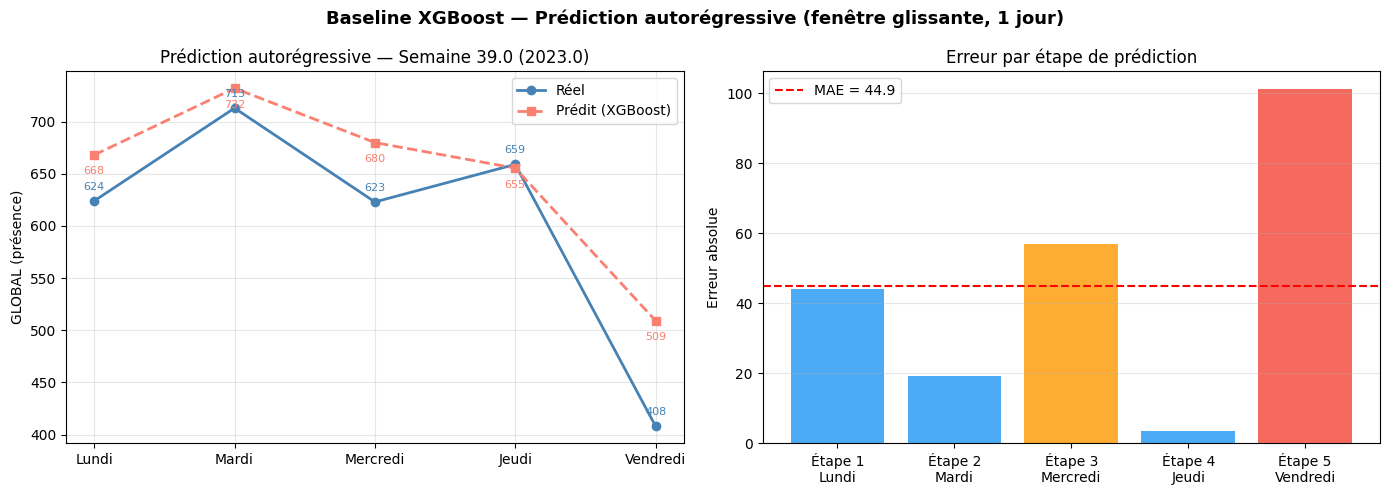

Figure sauvegardée dans img/baseline_xgboost.png


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Graphique 1 : réel vs prédit sur la dernière semaine ---
ax = axes[0]
x_pos = np.arange(WINDOW_SIZE)

ax.plot(x_pos, actuals,     marker='o', linewidth=2, label='Réel',             color='steelblue')
ax.plot(x_pos, predictions, marker='s', linewidth=2, label='Prédit (XGBoost)', color='salmon', linestyle='--')

for i in range(WINDOW_SIZE):
    ax.annotate(f'{actuals[i]:.0f}',     (x_pos[i], actuals[i]),     textcoords='offset points', xytext=(0, 8),  ha='center', fontsize=8, color='steelblue')
    ax.annotate(f'{predictions[i]:.0f}', (x_pos[i], predictions[i]), textcoords='offset points', xytext=(0, -14), ha='center', fontsize=8, color='salmon')

ax.set_xticks(x_pos)
ax.set_xticklabels(day_labels)
ax.set_ylabel('GLOBAL (présence)')
ax.set_title(f"Prédiction autorégressive — Semaine {last_week_meta['Semaine']} ({last_week_meta['Annee']})")
ax.legend()
ax.grid(alpha=0.3)

# --- Graphique 2 : erreur cumulée à chaque étape ---
ax2 = axes[1]
errors = np.abs(actuals - predictions)
ax2.bar(x_pos, errors, color=['#2196F3' if e < 50 else '#FF9800' if e < 100 else '#F44336' for e in errors], alpha=0.8)
ax2.axhline(mae, color='red', linestyle='--', label=f'MAE = {mae:.1f}')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Étape {i+1}\n{d}' for i, d in enumerate(day_labels)])
ax2.set_ylabel('Erreur absolue')
ax2.set_title('Erreur par étape de prédiction')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Baseline XGBoost — Prédiction autorégressive (fenêtre glissante, 1 jour)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../img/baseline_xgboost.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure sauvegardée dans img/baseline_xgboost.png')

## 6. Importance des features

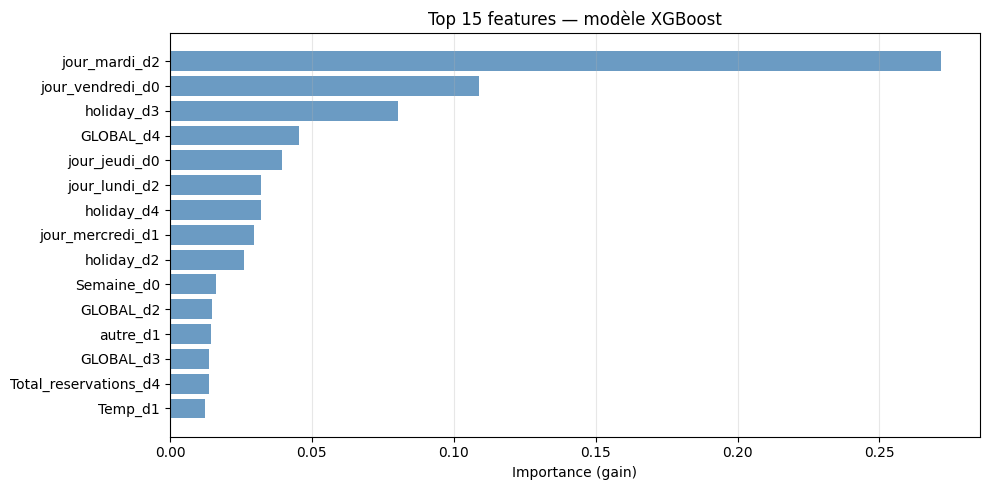

In [21]:
importances = model.feature_importances_
top_n = 15

sorted_idx = np.argsort(importances)[::-1][:top_n]
top_names  = [feature_names[i] for i in sorted_idx]
top_vals   = importances[sorted_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(top_names[::-1], top_vals[::-1], color='steelblue', alpha=0.8)
ax.set_xlabel('Importance (gain)')
ax.set_title(f'Top {top_n} features — modèle XGBoost')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()